# Analysis 2 coef
- Model: Logistic regression
- Risk score: calculated based on adjusted beta coefficients from multivariate analysis
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 
- Predicts 5 year risk for combined UGI cancer

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
from scipy.stats import percentileofscore
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path
from functools import reduce

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [8]:
univariate_filename = './../results/univariate_analysis_2_coef.csv'
multivariate_filename = './../results/multivariate_analysis_2_coef.csv'
risk_results_filename = './../results/risk_results_analysis_2_coef.csv'

In [9]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean']
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis - logistic regression

In [10]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening",
    "hgball_baseline_imputed_mean"
)

subtype_outcomes <- c('ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC')

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex"                           "sex_missing"                  
 [3] "race_clean"                    "race_clean_missing"           
 [5] "ethnicity"                     "ethnicity_missing"            
 [7] "alcohol_all"                   "alcohol_binary"               
 [9] "tobacco_all"                   "tobacco_all_missing"          
[11] "tobacco_binary"                "tobacco_binary_missing"       
[13] "hpylori_active"                "hpylori_active_chronic"       
[15] "hpylori_active_chronic_binary" "hnca"                         
[17] "achalasia"                     "pud"                          
[19] "gerd"                          "cad"                          
[21] "barretts"                      "famhx_cancer"                 
[23] "famhx_esophagealca"            "famhx_gastricca"              
[25] "famhx_colonca"                 "famhx_barretts"               
[27] "ASA"                           "PPI"                          
[29] "NSAID"                      

In [13]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("ugica ~", i))
    
    model <- glm(formula, data=r_df_normal, family = binomial)

    model_summary <- summary(model)

    # Get odds ratios and confidence intervals
    coef <- exp(coef(model))
    confint_vals <- exp(confint(model))  # 95% CI for log-odds, exponentiated to OR
    p_value <- coef(summary(model))[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(coef(summary(model)))

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        OR = coef[terms],
        CI_lower = confint_vals[terms, 1],
        CI_upper = confint_vals[terms, 2],
        p_value = p_value[terms]
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex.(Intercept),sex,(Intercept),0.000104,0.000084,0.000126,0.000000e+00
1,sex.sexMALE,sex,MALE,2.576787,2.034628,3.287300,9.657793e-15
3,sex_missing.(Intercept),sex_missing,(Intercept),0.000104,0.000084,0.000126,0.000000e+00
4,sex_missing.sex_missingMALE,sex_missing,MALE,2.576787,2.034629,3.287298,9.657712e-15
5,race_clean.(Intercept),race_clean,(Intercept),0.000212,0.000179,0.000249,0.000000e+00
...,...,...,...,...,...,...,...
107,ugica_10yr.(Intercept),ugica_10yr,(Intercept),0.000011,0.000007,0.000017,0.000000e+00
109,escc_10yr.(Intercept),escc_10yr,(Intercept),0.000149,0.000132,0.000168,0.000000e+00
111,eac_10yr.(Intercept),eac_10yr,(Intercept),0.000141,0.000124,0.000159,0.000000e+00
113,cgc_10yr.(Intercept),cgc_10yr,(Intercept),0.000144,0.000127,0.000163,0.000000e+00


## Feature selection

In [16]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

duplicate_vars <- c("sex", "ethnicity_missing", "tobacco_all", "tobacco_all_missing", "tobacco_binary_missing", "barretts")
selected_vars <- selected_vars[
    !selected_vars %in% duplicate_vars &
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"         "race_clean"          "ethnicity"          
 [4] "tobacco_binary"      "hnca"                "pud"                
 [7] "gerd"                "cad"                 "famhx_cancer"       
[10] "famhx_gastricca"     "famhx_colonca"       "ASA"                
[13] "PPI"                 "NSAID"               "age"                
[16] "visit_year_bucket"   "age_bucket"          "meets_eac_screening"


## Logistic regression multivariate model training

In [17]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(subtype_outcomes), all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = glm) {
  formula_str <- paste("ugica ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set, family = binomial)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(logreg_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    logreg_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      OR_scaled = estimate / min(estimate, na.rm = TRUE),
      OR_rank = round(OR_scaled)
  )

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  return(risk)
}

# Gets actual event 
count_event <- function(validation_set, outcome, horizon_months = 60) {
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set[[outcome]] == 1)
  return(event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine




#### Split dataset into training and validation

In [18]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_model(train_set, selected_vars, model_func=glm)

[1] "Dataset Controls 33871" "Dataset Cases 312"     
[1] "Training Controls 27103" "Training Cases 244"     
[1] "Validation Controls 6768" "Validation Cases 68"     



#### Multivariate analysis

In [19]:
%%R 
# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(logreg_model, multivariate_filename, variable_labels)


Multivariate results saved to ./../results/multivariate_analysis_2_coef.csv 


In [20]:
df_multivariate = pd.read_csv(multivariate_filename)[['variable', 'label', 'p.value', 'OR_scaled', 'OR_rank']]
df_multivariate

,variable,label,p.value,OR_scaled,OR_rank
0,sex_missing,FEMALE,NaN,4.606019,5
1,sex_missing,MALE,4.103196e-04,8.433732,8
2,race_clean,White,NaN,4.606019,5
3,race_clean,Asian,3.203909e-03,10.780098,11
4,race_clean,Black or African American,4.447656e-01,3.867115,4
5,race_clean,No matching concept,3.340794e-01,3.617579,4
6,race_clean,Other,9.418361e-01,4.749711,5
7,ethnicity,Not Hispanic or Latino,NaN,4.606019,5
8,ethnicity,Hispanic or Latino,1.290829e-01,6.462950,6
9,ethnicity,No matching concept,7.389385e-03,2.236042,2


#### Calculate risk score 

In [21]:
%%R 
# Convert all factor columns in validation_set to character
validation_set[] <- lapply(validation_set, function(x) {
  if (is.factor(x)) as.character(x) else x
})

In [22]:
# Fetch the R object
validation_set_r = ro.r['validation_set']

# Convert to pandas dataframe
validation_df = pandas2ri.rpy2py(validation_set_r)

In [23]:
validation_risk_df = validation_df.copy()
# Variables that will determine risk score
df_variables_risk = df_multivariate[df_multivariate['p.value'] <= 0.05]
df_variables_risk

,variable,label,p.value,OR_scaled,OR_rank
1,sex_missing,MALE,4.103196e-04,8.433732,8
3,race_clean,Asian,3.203909e-03,10.780098,11
9,ethnicity,No matching concept,7.389385e-03,2.236042,2
15,pud,1,4.736899e-09,16.313245,16
17,gerd,1,8.185570e-04,8.068147,8
21,famhx_cancer,1,6.477385e-06,9.040041,9
23,famhx_gastricca,1,1.814354e-04,13.974183,14
27,ASA,1,7.244454e-04,2.004300,2
29,PPI,1,4.263750e-04,8.892664,9
35,visit_year_bucket,2019-2022,1.483135e-07,1.000000,1


In [24]:
def get_risk_score(row, df_variables):
    risk_score = 0

    # Loop through each variable in the multivariate analysis and add to the score
    for variable in df_variables.variable.unique(): 
        variable_risks = df_variables[df_variables.variable == variable]
        labels_set = set(variable_risks.label)
        value = row[variable]
        if value in labels_set: 
            match = variable_risks[variable_risks.label == value]
            additional_risk = int(match.OR_rank.iloc[0])
            # print(value, additional_risk)
            risk_score += additional_risk
    return risk_score

validation_risk_df['risk_score'] = validation_risk_df.apply(lambda row: get_risk_score(row, df_variables_risk), axis=1)


In [25]:
# Pass back to R 
ro.globalenv['validation_risk_r_df'] = validation_risk_df

## Results

### Predict events

In [48]:
%%R 
# Estimate risk
risk_5_years <- validation_risk_r_df$risk_score
event_5_years <- count_event(validation_set, "ugica")

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event_ugica = validation_set$ugica,
    event_escc = validation_set$ugica_ESCC,
    event_eac = validation_set$ugica_EAC,
    event_cgc = validation_set$ugica_CGC,
    event_ncgc = validation_set$ugica_NCGC,

    race = validation_set$race_clean,

    pred_risk = risk_5_years,
    
    ugica_5yr = event_5_years,
    escc_5yr = count_event(validation_set, "ugica_ESCC"),
    eac_5yr = count_event(validation_set, "ugica_EAC"),
    cgc_5yr = count_event(validation_set, "ugica_CGC"),
    ncgc_5yr = count_event(validation_set, "ugica_NCGC")
)

# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.726 
Sensitivity: 0.675 
Specificity: 0.6187463 
PPV: 0.01031322 
NPV: 0.996918 
NNS: 138.2899 
     predicted_class
event    0    1
    0 4205 2591
    1   13   27


In [27]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,pred_risk,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr
1,59.071869,0,0,0,0,0,No matching concept,19,0.0,0.0,0.0,0.0,0.0
2,4.993840,0,0,0,0,0,No matching concept,19,0.0,0.0,0.0,0.0,0.0
3,66.726899,0,0,0,0,0,White,27,0.0,0.0,0.0,0.0,0.0
4,157.043121,0,0,0,0,0,No matching concept,11,0.0,0.0,0.0,0.0,0.0
5,0.164271,0,0,0,0,0,White,26,0.0,0.0,0.0,0.0,0.0


### Sensitivity and Metrics at threshold that maximizes Youdens

In [49]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.726 
Sensitivity: 0.525 
Specificity: 0.8379929 
PPV: 0.01871658 
NPV: 0.9966748 
NNS: 64.9713 
     predicted_class
event    0    1
    0 5695 1101
    1   19   21


### AUROC curves and PR curve

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



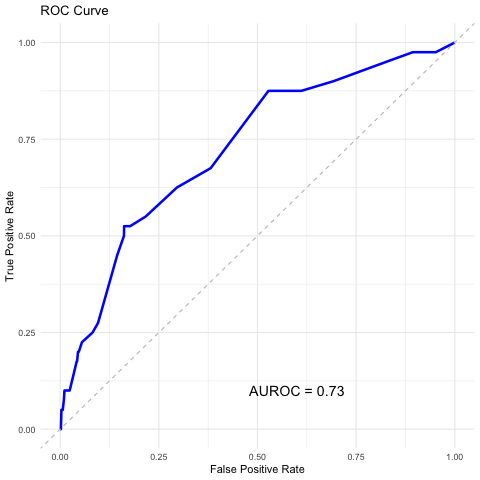

In [29]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

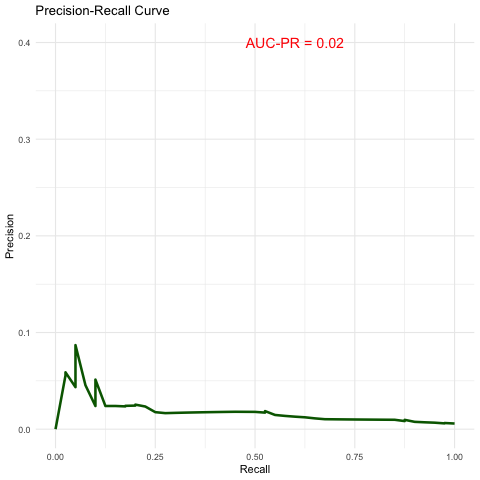

In [30]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [31]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,pred_risk,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr
1,59.071869,0,0,0,0,0,No matching concept,19,0.0,0.0,0.0,0.0,0.0
2,4.993840,0,0,0,0,0,No matching concept,19,0.0,0.0,0.0,0.0,0.0
3,66.726899,0,0,0,0,0,White,27,0.0,0.0,0.0,0.0,0.0
4,157.043121,0,0,0,0,0,No matching concept,11,0.0,0.0,0.0,0.0,0.0
5,0.164271,0,0,0,0,0,White,26,0.0,0.0,0.0,0.0,0.0


In [32]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]
max_risk_score = df_variables_risk.groupby('variable').max('OR_rank').OR_rank.sum()

# One-hot encoding for each risk score group
for risk_score in range(0, max_risk_score): 
    risk_col = f"risk_{risk_score}"
    df_validation_risk[risk_col] = np.where(df_validation_risk['pred_risk'] >= risk_score, 1, 0)

# Optimal Youden threshold cutoff
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk['pred_risk'] >= optimal_threshold, 1, 0)


In [33]:
def classification_metrics(predicted_risk_df, risk_group_name, actual_event_name, race = 'all'):
    predicted_class = predicted_risk_df[risk_group_name]
    actual_class = predicted_risk_df[actual_event_name]

    # Get confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    total_in_risk_group = predicted_class.sum() #tp+fp
    total_cases_in_risk_group = tp
    prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1) 

    # Return as dictionary
    return {
        "risk_group": risk_group_name,
        "risk_score": (risk_group_name[5:]),
        "event": actual_event_name,
        "race": race,
        "actual controls": fp+tn,
        "actual cases": tp+fn,
        "total pts in risk group": total_in_risk_group,
        "cancer prevalence in risk group": f'{total_cases_in_risk_group} ({prevalence_in_risk_group}%)',
        "prevalence": prevalence_in_risk_group,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "pred correct": (tp+tn)/(tp+fp+fn+tn),
        "pred incorrect": (fp+fn)/(tp+fp+fn+tn),
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [34]:
risk_groups = [f"risk_{i}" for i in range(0, max_risk_score)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']
race_groups = df_validation_risk.race.unique()

results_by_riskgroup = []
results_by_race = []

for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_by_riskgroup.append(row)

for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", 'ugica_5yr', race)
    results_by_race.append(row)

df_results = pd.DataFrame(results_by_riskgroup)
df_results_race = pd.DataFrame(results_by_race)

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_96013/3031450130.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_96013/3031450130.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_96013/3031450130.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_96013/3031450130.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipy

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [35]:
df_results

,risk_group,risk_score,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,risk_0,0,ugica_5yr,all,6796,40,6836,40 (0.6%),0.6,40,6796,0,0,0.005851,0.994149,100.0,0.0,0.585138,0.000000,0.0
1,risk_0,0,escc_5yr,all,6827,9,6836,9 (0.1%),0.1,9,6827,0,0,0.001317,0.998683,100.0,0.0,0.131656,0.000000,0.0
2,risk_0,0,eac_5yr,all,6829,7,6836,7 (0.1%),0.1,7,6829,0,0,0.001024,0.998976,100.0,0.0,0.102399,0.000000,0.0
3,risk_0,0,cgc_5yr,all,6825,11,6836,11 (0.2%),0.2,11,6825,0,0,0.001609,0.998391,100.0,0.0,0.160913,0.000000,0.0
4,risk_0,0,ncgc_5yr,all,6823,13,6836,13 (0.2%),0.2,13,6823,0,0,0.001902,0.998098,100.0,0.0,0.190170,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,risk_79,79,ugica_5yr,all,6796,40,0,0 (nan%),NaN,0,0,40,6796,0.994149,0.005851,0.0,100.0,0.000000,99.414862,0.0
396,risk_79,79,escc_5yr,all,6827,9,0,0 (nan%),NaN,0,0,9,6827,0.998683,0.001317,0.0,100.0,0.000000,99.868344,0.0
397,risk_79,79,eac_5yr,all,6829,7,0,0 (nan%),NaN,0,0,7,6829,0.998976,0.001024,0.0,100.0,0.000000,99.897601,0.0
398,risk_79,79,cgc_5yr,all,6825,11,0,0 (nan%),NaN,0,0,11,6825,0.998391,0.001609,0.0,100.0,0.000000,99.839087,0.0


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [36]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_score,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
3,risk_0,0,cgc_5yr,all,6825,11,6836,11 (0.2%),0.2,11,6825,0,0,0.001609,0.998391,100.0,0.000000,0.160913,0.000000,0.000000
8,risk_1,1,cgc_5yr,all,6825,11,6509,11 (0.2%),0.2,11,6498,0,327,0.049444,0.950556,100.0,4.791209,0.168997,100.000000,0.047912
53,risk_10,10,cgc_5yr,all,6825,11,4744,11 (0.2%),0.2,11,4733,0,2092,0.307636,0.692364,100.0,30.652015,0.231872,100.000000,0.306520
58,risk_11,11,cgc_5yr,all,6825,11,4188,11 (0.3%),0.3,11,4177,0,2648,0.388970,0.611030,100.0,38.798535,0.262655,100.000000,0.387985
63,risk_12,12,cgc_5yr,all,6825,11,3792,11 (0.3%),0.3,11,3781,0,3044,0.446899,0.553101,100.0,44.600733,0.290084,100.000000,0.446007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,risk_77,77,ugica_5yr,all,6796,40,0,0 (nan%),NaN,0,0,40,6796,0.994149,0.005851,0.0,100.000000,0.000000,99.414862,0.000000
390,risk_78,78,ugica_5yr,all,6796,40,0,0 (nan%),NaN,0,0,40,6796,0.994149,0.005851,0.0,100.000000,0.000000,99.414862,0.000000
395,risk_79,79,ugica_5yr,all,6796,40,0,0 (nan%),NaN,0,0,40,6796,0.994149,0.005851,0.0,100.000000,0.000000,99.414862,0.000000
40,risk_8,8,ugica_5yr,all,6796,40,6112,39 (0.6%),0.6,39,6073,1,723,0.111469,0.888531,97.5,10.638611,0.638089,99.861878,0.081386


In [37]:
df_results.to_csv(risk_results_filename)

### Performance metrics by race at the optimal risk percentile

In [38]:
df_results_race

,risk_group,risk_score,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,high_risk_youden,risk_youden,ugica_5yr,No matching concept,2326,12,322,6 (1.9%),1.9,6,316,6,2010,0.862275,0.137725,50.000000,86.414445,1.863354,99.702381,0.364144
1,high_risk_youden,risk_youden,ugica_5yr,White,2513,19,414,10 (2.4%),2.4,10,404,9,2109,0.836888,0.163112,52.631579,83.923597,2.415459,99.575071,0.365552
2,high_risk_youden,risk_youden,ugica_5yr,Black or African American,1470,6,199,4 (2.0%),2.0,4,195,2,1275,0.866531,0.133469,66.666667,86.734694,2.010050,99.843383,0.534014
3,high_risk_youden,risk_youden,ugica_5yr,Asian,273,3,163,1 (0.6%),0.6,1,162,2,111,0.405797,0.594203,33.333333,40.659341,0.613497,98.230088,-0.260073
4,high_risk_youden,risk_youden,ugica_5yr,Other,214,0,24,0 (0.0%),0.0,0,24,0,190,0.887850,0.112150,0.000000,88.785047,0.000000,100.000000,-0.112150


### Prevalance of cancer as a function of risk percentile by subtype

In [39]:
event_pretty_label = {
    "ugica_5yr": "UGI cancer", 
    "escc_5yr": "Esophageal SCC",
    "eac_5yr": "Esophageal AC",
    "cgc_5yr": "Cardia Gastric AC",
    "ncgc_5yr": "Noncardia Gastric AC"
}

In [40]:
df_results.head()

,risk_group,risk_score,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,risk_0,0,ugica_5yr,all,6796,40,6836,40 (0.6%),0.6,40,6796,0,0,0.005851,0.994149,100.0,0.0,0.585138,0.0,0.0
1,risk_0,0,escc_5yr,all,6827,9,6836,9 (0.1%),0.1,9,6827,0,0,0.001317,0.998683,100.0,0.0,0.131656,0.0,0.0
2,risk_0,0,eac_5yr,all,6829,7,6836,7 (0.1%),0.1,7,6829,0,0,0.001024,0.998976,100.0,0.0,0.102399,0.0,0.0
3,risk_0,0,cgc_5yr,all,6825,11,6836,11 (0.2%),0.2,11,6825,0,0,0.001609,0.998391,100.0,0.0,0.160913,0.0,0.0
4,risk_0,0,ncgc_5yr,all,6823,13,6836,13 (0.2%),0.2,13,6823,0,0,0.001902,0.998098,100.0,0.0,0.190170,0.0,0.0


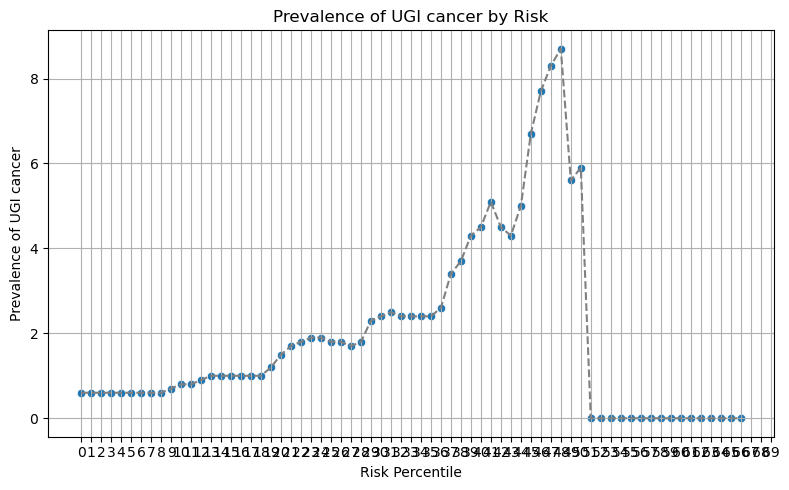

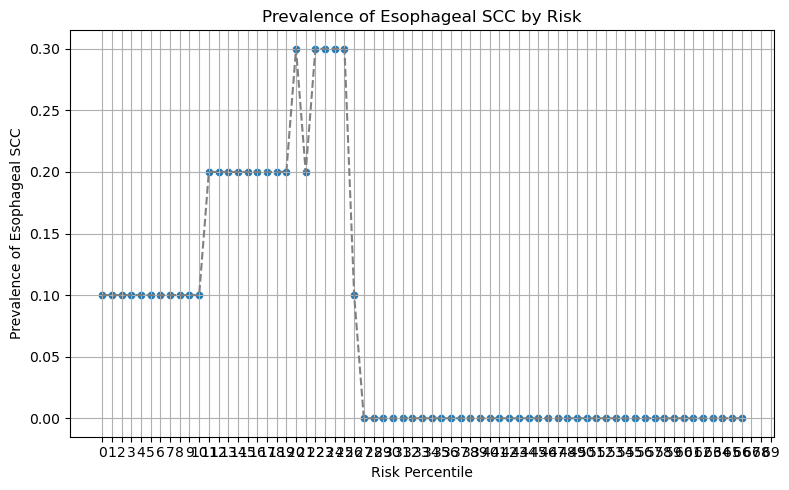

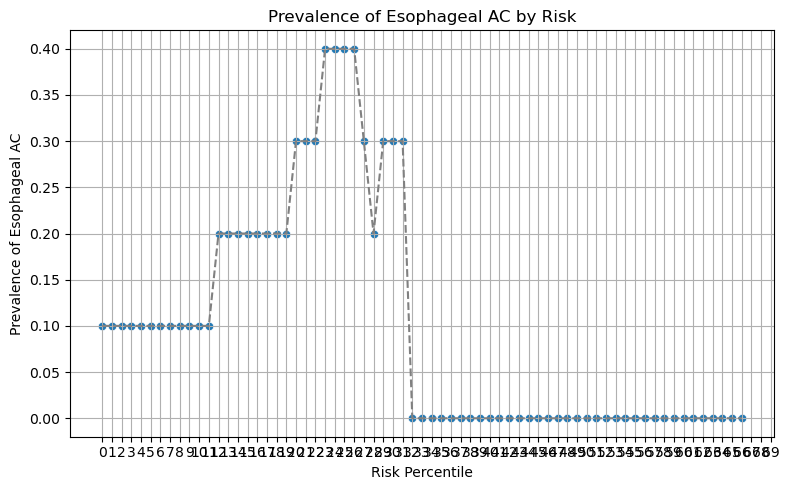

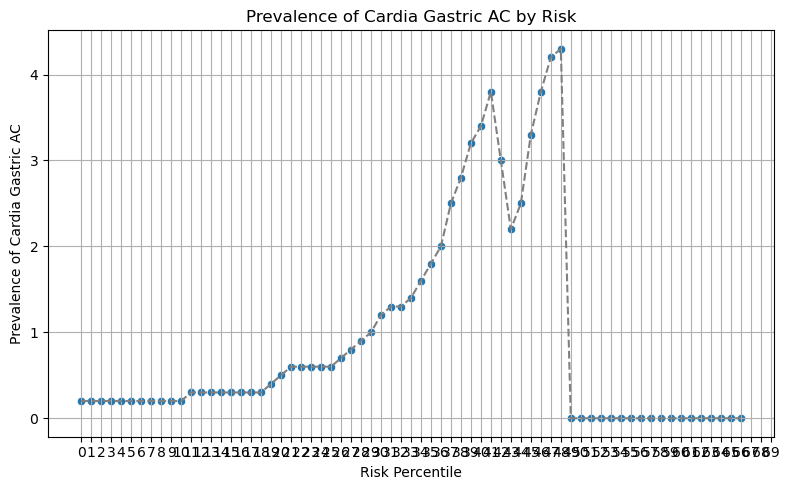

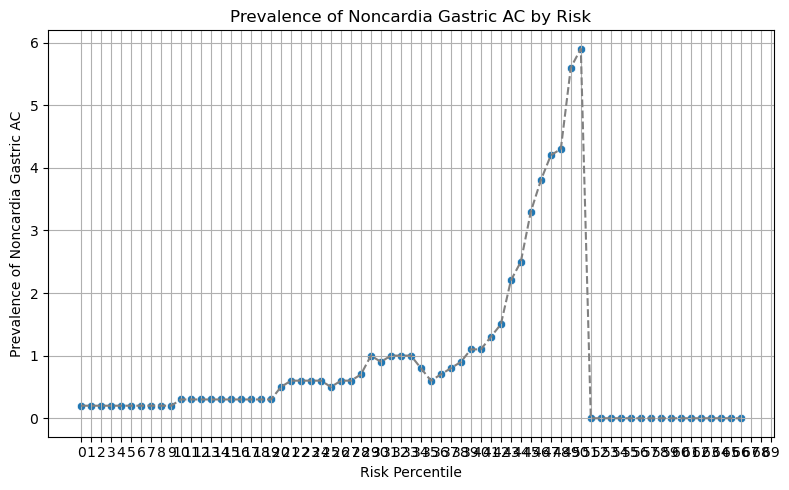

In [41]:
risk_group = 'risk_score'
df_results_plot = df_results[df_results[risk_group] != 'risk_youden']

for event in events_5yr:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x=risk_group, y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x=risk_group, y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Percentile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}')
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Kaplan Meier survival curves stratified by risk group

In [42]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,5695,1101
1.0,19,21


In [43]:
# Pass dataframe to R to analyze
pass_df(df_validation_risk, 'r_df_validation_risk')

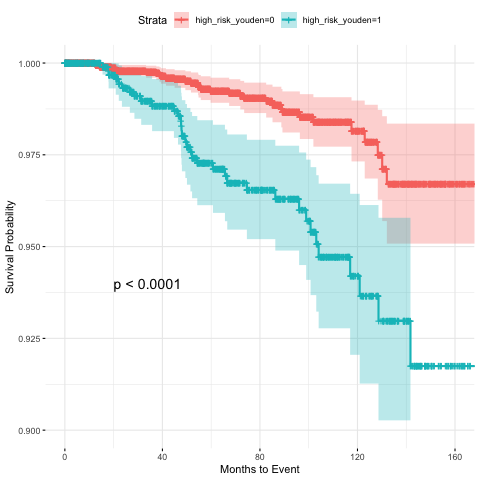

In [44]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot

### Save model, threshold and validation set

In [45]:
%%R 
# Save model
saveRDS(logreg_model, "logreg_all.rds")

In [46]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [47]:
model = 'logreg'
subtype = 'combined'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
